## Credit Card Default Prediction Project

This project consists of implementing and end-to-end Machine Learning project, covering the following aspects along the model development cycle:

* Problem definition
* Imports
* Data splitting
* Exploratory Data Analysis (EDA)
* Feature Engineering
* Data preprocessing and pipelines
* Baseline model
* Candidate models
* Feature selection
* Hyperparameter optimization
* Best model interpretation and feature importances
* Test set results and model evaluation
* Summary of results

The project was developed as part of the Feature and Model Selection course (DSCI 573) offered at the Master's in Data Science and Computational Linguistics program at the University of British Columbia.

### Problem definition

The problem consists of developing and training a classification model capable of predicting whether credit card holders of a given financial institution will default on their next monthly credit card payment. The dataset given for this problem is the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset), which contains 30,000 examples and 24 features.

According to both the [Kaggle website](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) and [this study](https://www.sciencedirect.com/science/article/pii/S0957417407006719), the variable description can be summarized as follows:
* `ID`: Discrete, unqiue ID for each client.
* `LIMIT_BAL`: Continuous, denotes the amount of credit given in NT dollars.
* `SEX`: Discrete, denotes a binary gender classification, assigning 1 for male and 2 for female.
* `EDUCATION`: Discrete, denotes a classification of educational levels from 1 to 3, with 1 being the highest level received. 4 represents "others".
* `MARRIAGE`: Discrete, assigning 1 for married, 2 for single and 3 for others.
* `AGE`: Discrete, age of the person.
* `PAY1...PAY2...PAY6`: Discrete, denotes repayment status for that particular month. The measurement scale for the repayment status is: −1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; …; 8 = payment delay for eight months; 9 = payment delay for nine months and above. According to [this discussion](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/157664), -2 means that there are not payments to be made on that month and that the account was "inactive" during this month.
* `BILL_AMT1...BILL_AMT2...BILL_AMT6`: Continuous, the amount of bill statement for that particular month.
* `PAY_AMT1...PAY_AMT2...PAY_AMT6`: Continuous, the amount of previous payments made for that particular month.

The target variable is `deafult.payment.next.month` which assigns a `1` in case there was a recorded default and `0` otherwise.

### Imports

In [1]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import xgboost as xgb

# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import classification_report
import eli5
import shap

# data viz
import seaborn as sns

/Users/JJR/opt/miniconda3/envs/573/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/JJR/opt/miniconda3/envs/573/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data splitting

In [2]:
data = pd.read_csv("data/UCI_Credit_Card.csv")
train_df, test_df = train_test_split(data, test_size=0.2, random_state=20)
train_df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
5454,5455,80000.0,2,3,2,31,0,0,0,2,...,40766.0,39982.0,44621.0,2000.0,5200.0,1700.0,0.0,5500.0,0.0,0
19336,19337,390000.0,2,2,2,35,0,0,0,0,...,28352.0,28066.0,28215.0,2389.0,2414.0,2378.0,892.0,925.0,938.0,0
13414,13415,240000.0,1,1,2,34,1,2,-1,-1,...,9124.0,7128.0,2745.0,14.0,9497.0,9124.0,2000.0,1200.0,1000.0,0
26799,26800,40000.0,1,1,2,31,0,0,-1,-1,...,2601.0,1759.0,-125.0,1000.0,200.0,2601.0,100.0,0.0,2412.0,0
20155,20156,200000.0,2,2,2,38,0,0,0,2,...,1195.0,43115.0,43869.0,1533.0,2395.0,0.0,45000.0,1600.0,2000.0,0


### EDA

In [3]:
# General info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 11401 to 15715
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          24000 non-null  int64  
 1   LIMIT_BAL                   24000 non-null  float64
 2   SEX                         24000 non-null  int64  
 3   EDUCATION                   24000 non-null  int64  
 4   MARRIAGE                    24000 non-null  int64  
 5   AGE                         24000 non-null  int64  
 6   PAY_0                       24000 non-null  int64  
 7   PAY_2                       24000 non-null  int64  
 8   PAY_3                       24000 non-null  int64  
 9   PAY_4                       24000 non-null  int64  
 10  PAY_5                       24000 non-null  int64  
 11  PAY_6                       24000 non-null  int64  
 12  BILL_AMT1                   24000 non-null  float64
 13  BILL_AMT2                  

In [4]:
# Summary statistics for train_df
train_df.drop(columns = "ID").describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,167748.320000,1.604708,1.852583,1.552083,35.49600,-0.022583,-0.140458,-0.167125,-0.224542,-0.270875,...,43303.657708,40221.376458,38784.710250,5708.616292,5.983342e+03,5276.174542,4810.167542,4804.440125,5219.962667,0.220792
std,129937.292115,0.488923,0.791282,0.522381,9.20757,1.115665,1.188117,1.193979,1.166696,1.130142,...,64549.352943,60810.507510,59634.687504,16846.602862,2.438430e+04,18158.974275,15673.765287,15398.470427,18002.709758,0.414789
min,10000.000000,1.000000,0.000000,0.000000,21.00000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2257.750000,1721.250000,1229.750000,995.250000,8.157500e+02,390.000000,286.750000,248.750000,110.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19001.000000,18043.500000,17039.500000,2100.000000,2.010000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54717.750000,50237.250000,49115.000000,5005.000000,5.000000e+03,4500.000000,4000.000000,4000.250000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.00000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Class balance: 0    0.779208
1    0.220792
Name: default.payment.next.month, dtype: float64


<AxesSubplot:>

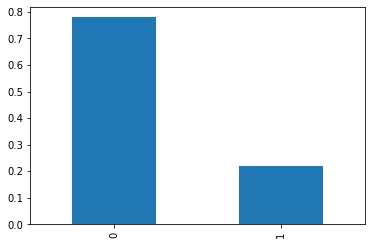

In [5]:
# Class balance
class_balance = train_df["default.payment.next.month"].value_counts(normalize = True)
print(f"Class balance: {class_balance}")
class_balance.plot.bar()

> This plot visualizes the class balance on `deafult.payment.next.month`. As we can see, there's class imbalance with `class 0` representing aprox. 78% of the total targets.

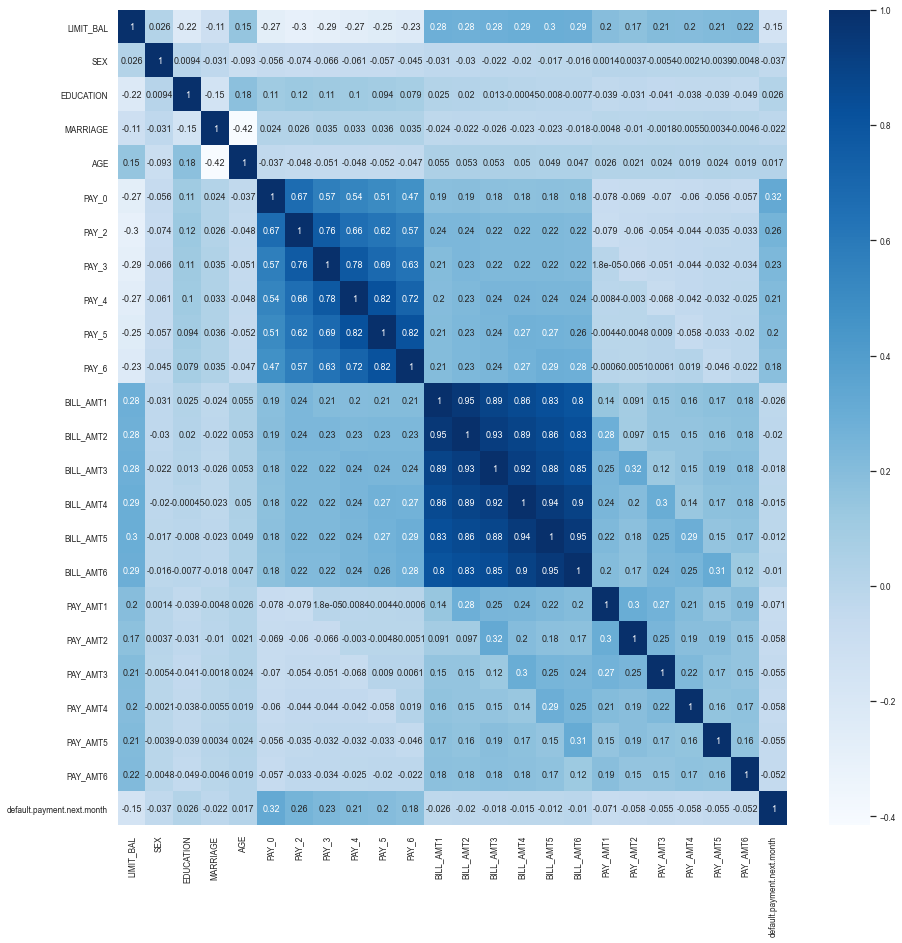

In [6]:
# Feature correlations with the target value
corr = train_df.drop(columns = "ID").corr()
plt.figure(figsize=(15,15))
sns.set(font_scale=0.75)
sns.heatmap(corr, cmap=plt.cm.Blues, annot = True)
plt.show()

> This correlation matrix plot visualizes the different Pearson's correlations among the features in the dataset and also with respect to the target value.

In [7]:
# Exploration of categorical variable "SEX"
train_df[['SEX']].value_counts()

SEX
2      14513
1       9487
dtype: int64

In [8]:
# Exploration of categorical variable "EDUCATION"
train_df[['EDUCATION']].value_counts()

EDUCATION
2            11172
1             8499
3             3950
5              223
4              105
6               39
0               12
dtype: int64

> Note: Anomalous values 0, 5 and 6.

In [9]:
# Exploration of categorical variable "MARRIAGE"
train_df[['MARRIAGE']].value_counts()

MARRIAGE
2           12768
1           10925
3             263
0              44
dtype: int64

> Note: Anomalous value 0.

In [10]:
# Exploration of categorical variable "AGE"
train_df[["AGE"]].describe()

,AGE
count,24000.00000
mean,35.49600
std,9.20757
min,21.00000
25%,28.00000
50%,34.00000
75%,41.00000
max,79.00000


In [11]:
# Payment status description
train_df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,-0.022583,-0.140458,-0.167125,-0.224542,-0.270875,-0.294000
std,1.115665,1.188117,1.193979,1.166696,1.130142,1.149436
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


> Note: Anomalous values -2 and 0.

In [12]:
# Bill Statement description
train_df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000
mean,51110.197083,49122.385208,4.706596e+04,43303.657708,40221.376458,38784.710250
std,73486.836071,71187.473486,6.970308e+04,64549.352943,60810.507510,59634.687504
min,-154973.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3497.750000,2906.750000,2.607750e+03,2257.750000,1721.250000,1229.750000
50%,22278.500000,21224.000000,2.001150e+04,19001.000000,18043.500000,17039.500000
75%,67435.750000,64242.000000,6.038625e+04,54717.750000,50237.250000,49115.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [13]:
# Previous Payment Description
train_df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,5708.616292,5.983342e+03,5276.174542,4810.167542,4804.440125,5219.962667
std,16846.602862,2.438430e+04,18158.974275,15673.765287,15398.470427,18002.709758
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,995.250000,8.157500e+02,390.000000,286.750000,248.750000,110.750000
50%,2100.000000,2.010000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4000.000000,4000.250000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


#### **Summary about the preliminary EDA:**
From the initial EDA performed, we can observe the following about `train_df`:

* The dataset is comprised entirely of numeric variables, with a mix of discrete and continuous values.
* There are no `NaN` values on the dataset. 
* Some feature labels are not named properly (such as `PAY_0`).
* There is class imbalance in the dataset, with `class 0` representing aprox. 78% of the target values in `default.payment.next.month`.
* There are 1.5x more women than men.
* Most of the information of the variable `AGE` seems to be clustered around 21 and 41 years.
* The columns `MARRIAGE` and `EDUCATION` contain anomolous values outside the "plausible" range for each category.
* The positive class is `class 1`.
* The features `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6` contain anomolous values outside the "plausible" range.
* The features `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6` are positively correlated to each other and with the target value. The correlation value seems to increase as the month number `N` decreases.
* The features `BILL_AMT1`, `BILL_AMT2`, `BILL_AMT3`, `BILL_AMT4`, `BILL_AMT5`, `BILL_AMT6` are highly positively correlated with each other. The correlation value seems to increase as the month number `N` decreases.
* The only feature that seems to hold a slight correlation with the target value is `PAY_0`.
* The continuous features `BILL_AMTN`, and `PAY_AMTN` (where `N` is the number of the corresponding month) all have a right-skewed distribution.
* The continous features `BILL_AMTN` contains negative values, which suggests some customers might have had negative balances in certain months.

Based on this information, we suggest conducting the following tasks during feature engineering and pre-processing:

* Drop the feature `ID` as it doesn't add value to the prediction.
* Drop the feature `SEX` as it might raise ethical concerns for being potentially discriminatory.
* Create different bins for the categorical variable `AGE`.
* Transform the anomolous values in columns `MARRIAGE` and `EDUCATION` so they appear under the "Others" category, instead of having their own independent column.
* Transform the anomolous values in columns `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6` so they are coherent with the binary representation of the problem (i.e 0 for "has paid", 1 - N otherwise).
* Create columns `AMT_PAID` and `AGG_BILL` with the sum of `BILL_AMTN` and `PAY_AMTN` respectively (where `N` is the number of the corresponding month).
* Create column `NET_BILL` which takes the aggregate amount of bill statements `AGG_BILL` and subtracts the total amount of payments done `PAY_AMTN` during the period.
* After having creating these three features, proceed to drop all the features in `BILL_AMTN` and `PAY_AMTN` as they seem to hold no association with the target value and also carry redundant information already contained on `AMT_PAID` AND `AGG_BILL`.
* Rename column `PAY_0` to `PAY_1`, and target column `default.payment.next.month` to `default_pay`. 

#### **Scoring metric for this problem**
Taking these initial observations into account, we believe `F1` score should be the appropriate scoring metric to measure the model performance, because we should care about finding the right balance between minimizing false positives (i.e. people that are falsely predicted to default on their credit card payments) and minimizing false negatives (people that the model fails to identify before defaulting on their payments).

In this way, we can minimize sounding false alarms that can create unnecessary frictions with our customers, while simultaneously optimizing the model predicting capabilities to spot potential customers at risk of default.

### Feature engineering

In [14]:
def total_amount_and_bills(train_df, test_df):
    """ Calculates aggregate credit card payments and billing statement amount.
    Parameters
    ----------
    train_df : DataFrame
        Dataset containing the training examples.
    test_df : DataFrame
        Dataset containing the test examples.
    Returns
    -------
    train_df_amount_paid : DataFrame
        Dataset containing the sum of payments made on training set data.
    train_df_agg_bill : DataFrame
        Dataset containing the aggregate billing statement amount on training set data.
    test_df_amount_paid : DataFrame
        Dataset containing the sum of payments made on test set data.
    test_df_agg_bill : DataFrame
        Dataset containing the aggregate billing statement amount on test set data.   
    
    """
    pay_cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
    bill_cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
    train_df_amount_paid = []
    test_df_amount_paid = []
    train_df_agg_bill = []
    test_df_agg_bill = []

    for row in train_df[pay_cols].iterrows():
        train_df_amount_paid.append((sum(row[1])))

    for row in train_df[bill_cols].iterrows():
        train_df_agg_bill.append((sum(row[1])))

    for row in test_df[pay_cols].iterrows():
        test_df_amount_paid.append((sum(row[1])))

    for row in test_df[bill_cols].iterrows():
        test_df_agg_bill.append((sum(row[1])))
    
    return train_df_amount_paid, train_df_agg_bill, test_df_amount_paid, test_df_agg_bill

In [15]:
# Creates train_df_fe and test_df_fe with the new features, as described in the EDA summary.
train_df_amount_paid, train_df_agg_bill, test_df_amount_paid, test_df_agg_bill = total_amount_and_bills(train_df, test_df)
train_df_fe = train_df.copy()
test_df_fe = test_df.copy()
train_df_fe["AMT_PAID"] = train_df_amount_paid
train_df_fe["AGG_BILL"] = train_df_agg_bill
train_df_fe["NET_BILL"] = train_df_fe["AGG_BILL"] - train_df_fe["AMT_PAID"]
test_df_fe["AMT_PAID"] = test_df_amount_paid
test_df_fe["AGG_BILL"] = test_df_agg_bill
test_df_fe["NET_BILL"] = test_df_fe["AGG_BILL"] - test_df_fe["AMT_PAID"]
age_bins = [20, 29, 39, 49, 59, 69, 81]
bins_cols = [1, 2, 3, 4, 5, 6]
train_df_fe['AGE_BINNED'] = pd.cut(train_df_fe['AGE'], age_bins, labels = bins_cols)
test_df_fe['AGE_BINNED'] = pd.cut(test_df_fe['AGE'], age_bins, labels = bins_cols)

In [16]:
print(f"Original training set shape: {train_df.shape}")
print(f"Shape of training set after feature engineering: {train_df_fe.shape}")
print(f"Original test set shape: {test_df.shape}")
print(f"Shape of test set after feature engineering: {test_df_fe.shape}")

Original training set shape: (24000, 25)
Shape of training set after feature engineering: (24000, 29)
Original test set shape: (6000, 25)
Shape of test set after feature engineering: (6000, 29)


### Data preprocessing and pipelines

In [17]:
# Clusters anomalous values in EDUCATION into category 4
train_df_anom = (train_df_fe["EDUCATION"] == 5) | (train_df_fe["EDUCATION"] == 6) | (train_df_fe["EDUCATION"]== 0)
test_df_anom = (test_df_fe["EDUCATION"] == 5) | (test_df_fe["EDUCATION"] == 6) | (test_df_fe["EDUCATION"]== 0)
train_df_fe.loc[train_df_anom, "EDUCATION"] = 4
test_df_fe.loc[test_df_anom, "EDUCATION"] = 4

# Clusters anomalous values in MARRIAGE into category 3
train_df_fe.loc[train_df_fe["MARRIAGE"] == 0, "MARRIAGE"] = 3
test_df_fe.loc[test_df_fe["MARRIAGE"] == 0, "MARRIAGE"] = 3

# Renames columns PAY_1 and default.payment.next.month
train_df_fe = train_df_fe.rename(columns = {"PAY_0" : "PAY_1", "default.payment.next.month" : "default_pay"})
test_df_fe = test_df_fe.rename(columns = {"PAY_0" : "PAY_1", "default.payment.next.month" : "default_pay"})

# Transforms -1 and -2 values in columns PAY_N and clusters them under value 0 (meaning that payment has been duly made)
train_df_fe_pay_anom = (train_df_fe["PAY_1"] == -2) | (train_df_fe["PAY_1"] == -1) | (train_df_fe["PAY_1"] == 0)
train_df_fe.loc[train_df_fe_pay_anom, "PAY_1"] = 0
train_df_fe_pay_anom = (train_df_fe["PAY_2"] == -2) | (train_df_fe["PAY_2"] == -1) | (train_df_fe["PAY_2"] == 0)
train_df_fe.loc[train_df_fe_pay_anom, "PAY_2"] = 0
train_df_fe_pay_anom = (train_df_fe["PAY_3"] == -2) | (train_df_fe["PAY_3"] == -1) | (train_df_fe["PAY_3"] == 0)
train_df_fe.loc[train_df_fe_pay_anom, "PAY_3"] = 0
train_df_fe_pay_anom = (train_df_fe["PAY_4"] == -2) | (train_df_fe["PAY_4"] == -1) | (train_df_fe["PAY_4"] == 0)
train_df_fe.loc[train_df_fe_pay_anom, "PAY_4"] = 0
train_df_fe_pay_anom = (train_df_fe["PAY_5"] == -2) | (train_df_fe["PAY_5"] == -1) | (train_df_fe["PAY_5"] == 0)
train_df_fe.loc[train_df_fe_pay_anom, "PAY_5"] = 0
train_df_fe_pay_anom = (train_df_fe["PAY_6"] == -2) | (train_df_fe["PAY_6"] == -1) | (train_df_fe["PAY_6"] == 0)
train_df_fe.loc[train_df_fe_pay_anom, "PAY_6"] = 0

test_df_fe_pay_anom = (test_df_fe["PAY_1"] == -2) | (test_df_fe["PAY_1"] == -1) | (test_df_fe["PAY_1"] == 0)
test_df_fe.loc[test_df_fe_pay_anom, "PAY_1"] = 0
test_df_fe_pay_anom = (test_df_fe["PAY_2"] == -2) | (test_df_fe["PAY_2"] == -1) | (test_df_fe["PAY_2"] == 0)
test_df_fe.loc[test_df_fe_pay_anom, "PAY_2"] = 0
test_df_fe_pay_anom = (test_df_fe["PAY_3"] == -2) | (test_df_fe["PAY_3"] == -1) | (test_df_fe["PAY_3"] == 0)
test_df_fe.loc[test_df_fe_pay_anom, "PAY_3"] = 0
test_df_fe_pay_anom = (test_df_fe["PAY_4"] == -2) | (test_df_fe["PAY_4"] == -1) | (test_df_fe["PAY_4"] == 0)
test_df_fe.loc[test_df_fe_pay_anom, "PAY_4"] = 0
test_df_fe_pay_anom = (test_df_fe["PAY_5"] == -2) | (test_df_fe["PAY_5"] == -1) | (test_df_fe["PAY_5"] == 0)
test_df_fe.loc[test_df_fe_pay_anom, "PAY_5"] = 0
test_df_fe_pay_anom = (test_df_fe["PAY_6"] == -2) | (test_df_fe["PAY_6"] == -1) | (test_df_fe["PAY_6"] == 0)
test_df_fe.loc[test_df_fe_pay_anom, "PAY_6"] = 0

# Creates list of numeric features, target_column, and drop_features
pay_cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
bill_cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
numeric_features = train_df_fe.drop(
    columns = ["ID", "SEX", "AGE"] + pay_cols + bill_cols + ["default_pay"]).columns.to_list()
target_column = "default_pay"
drop_features = ["ID", "SEX", "AGE"] + pay_cols + bill_cols

# Separates X and y
X_train, y_train = train_df_fe.drop(columns=target_column), train_df_fe[target_column]
X_test, y_test = test_df_fe.drop(columns=target_column), test_df_fe[target_column]

# Defines preprocessor with a simple column transformer
numeric_transformer = make_pipeline(StandardScaler())
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
)

In [18]:
print(f"Original training set shape: {train_df.shape}")
print(f"Shape of training set after feature preprocessing: {X_train.shape}")
print(f"Original test set shape: {test_df.shape}")
print(f"Shape of test set after feature preprocessing: {X_test.shape}")

Original training set shape: (24000, 25)
Shape of training set after feature preprocessing: (24000, 28)
Original test set shape: (6000, 25)
Shape of test set after feature preprocessing: (6000, 28)


> After conducting feature engineering and pre-processing, we ended up with a training set of shape `(24000, 28)` and test set of shape `(6000, 28)`. However, there are several columns that will be dropped (see `drop_features`), which are included in the `column_transformer` inside `numeric_transformer`.

### Baseline model

In [19]:
### Credit: This function is adapted from the lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation.
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [20]:
# Creates the baseline model and applies CV to it with f1 score
results = {}
dummy_clf = DummyClassifier(strategy="stratified")
results['DummyCLF'] = mean_std_cross_val_scores(dummy_clf, X_train, y_train, scoring="f1", return_train_score=True)
pd.DataFrame(results)

,DummyCLF
fit_time,0.004 (+/- 0.001)
score_time,0.003 (+/- 0.001)
test_score,0.220 (+/- 0.014)
train_score,0.220 (+/- 0.003)


> The results from the baseline model seem to be inline with the class imbalance problem.

### Candidate models

The following candidate models will be trained and evaluated:

* Logistic Regression
* Random Forest
* SVC
* XGBoost
* CatBoost

The first model to be trained and optimized is Logistic Regression, which will then be compared with the results of the other models (which are more computationally expensive to train and optimize).

In [21]:
# Logistic Regression pipeline
pipe_lr = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", random_state=20))

param_grid = {
    "logisticregression__C": 10.0 ** np.arange(-3, 3)
}

random_search = RandomizedSearchCV(pipe_lr, param_distributions=param_grid, n_jobs=-1, n_iter=6, cv=10, scoring="f1");
random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.3f}")

Best parameters: {'logisticregression__C': 0.001}
Best score: 0.527


In [23]:
# Other classifiers
scale_pos_weight = y_train.value_counts(normalize=True)[0] / y_train.value_counts(normalize=True)[1]
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced", random_state=20))
pipe_svc = make_pipeline(preprocessor, SVC(class_weight="balanced", random_state=20))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=20))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(scale_pos_weight=scale_pos_weight, random_state=20, verbose=0))

classifiers = {
    "Random Forest" : pipe_rf,
    "SVC": pipe_svc,
    'XGBoost' : pipe_xgb, 
    'CatBoost' : pipe_catboost
}

for clf, pipe in classifiers.items():
    print(f"Training model {clf}...")
    results[clf] = mean_std_cross_val_scores(pipe, X_train, y_train, scoring="f1", return_train_score=True);
    print(f"Training model {clf}...finished")
pd.DataFrame(results)

Training model Random Forest...
Training model Random Forest...finished
Training model SVC...
Training model SVC...finished
Training model XGBoost...
Training model XGBoost...finished
Training model CatBoost...
Training model CatBoost...finished


,DummyCLF,Random Forest,SVC,XGBoost,CatBoost
fit_time,0.004 (+/- 0.001),2.061 (+/- 0.082),14.354 (+/- 0.254),0.638 (+/- 0.014),9.405 (+/- 1.998)
score_time,0.003 (+/- 0.001),0.095 (+/- 0.004),1.086 (+/- 0.018),0.010 (+/- 0.001),0.010 (+/- 0.001)
test_score,0.220 (+/- 0.014),0.453 (+/- 0.013),0.523 (+/- 0.007),0.516 (+/- 0.012),0.535 (+/- 0.011)
train_score,0.220 (+/- 0.003),0.992 (+/- 0.001),0.540 (+/- 0.002),0.705 (+/- 0.005),0.622 (+/- 0.004)


#### **Summary of results**
After including four different classifiers, `Random Forest`, `SVC`, `XGBoost` and `CatBoost`, we can see that `CatBoost` slightly improves the results obtained from `LogisticRegression`. `SVC` and `XGBoost` also seem to perform at a similar level. On the other hand, `Random Forest` seesm to be the worst performing model of all.

`CatBoost` and `SVC` are the models that take the longest to train.

### Feature selection

We will proceed now to evaluate whether removing irrelevant features improves model performance. This procedure will be implemented in two models: `XGBoost` and `Logistic Regression`.

In [24]:
from sklearn.feature_selection import RFECV

pipe_xgb_rfe = make_pipeline(preprocessor, RFECV(
    XGBClassifier(scale_pos_weight=scale_pos_weight), cv=5, n_jobs=-1), XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=20))
pipe_lr_rfe = make_pipeline(preprocessor, RFECV(
    LogisticRegression(class_weight="balanced"), cv=5, n_jobs=-1), LogisticRegression(class_weight="balanced", C=0.01, random_state=20))

classifiers_rfe = {
    'XGBoost (RFE)': pipe_xgb_rfe,
    'LogisticRegression (RFE)': pipe_lr_rfe, 
}

for clf, pipe in classifiers_rfe.items():
    results[clf]=mean_std_cross_val_scores(pipe, X_train, y_train, scoring="f1", return_train_score=True);
pd.DataFrame(results)

,DummyCLF,Random Forest,SVC,XGBoost,CatBoost,XGBoost (RFE),LogisticRegression (RFE)
fit_time,0.004 (+/- 0.001),2.061 (+/- 0.082),14.354 (+/- 0.254),0.638 (+/- 0.014),9.405 (+/- 1.998),26.387 (+/- 0.847),0.782 (+/- 0.017)
score_time,0.003 (+/- 0.001),0.095 (+/- 0.004),1.086 (+/- 0.018),0.010 (+/- 0.001),0.010 (+/- 0.001),0.010 (+/- 0.001),0.008 (+/- 0.002)
test_score,0.220 (+/- 0.014),0.453 (+/- 0.013),0.523 (+/- 0.007),0.516 (+/- 0.012),0.535 (+/- 0.011),0.508 (+/- 0.011),0.508 (+/- 0.011)
train_score,0.220 (+/- 0.003),0.992 (+/- 0.001),0.540 (+/- 0.002),0.705 (+/- 0.005),0.622 (+/- 0.004),0.508 (+/- 0.003),0.508 (+/- 0.003)


#### **Summary of results**
We selected `LogisticRegression` and `XGBoost` as a proof of concept for this experiment, due to being computationally less expensive than the other classifiers. After applying `RFECV` to both of them we can see that not only test scores do not improve but actually decrease. Hence, we will stick to the current number of features after performing the feature engineering process.

### Hyperparameter optimization

We will use `RandomSearchCV` as the method of choice for our hyperparameter optimization exploration.

In [26]:
# Defines the parameter grids for each model
lr_param_grid = {
    "logisticregression__penalty": ["l1", "l2", "elasticnet", "none"],
    "logisticregression__max_iter": np.random.randint(1, 500, 6),
}

rf_param_grid = {
    "randomforestclassifier__n_estimators": np.random.randint(1, 1000, 6),
    "randomforestclassifier__max_depth": np.random.randint(1, 250, 6),
}

svc_param_grid = {
    "svc__gamma": 10.0 ** np.arange(-3, 3),
    "svc__C": 10.0 ** np.arange(-3, 3),
}

xgb_param_grid = {
    "xgbclassifier__n_estimators": np.random.randint(1, 1000, 6),
}

catboost_param_grid = {
    "catboostclassifier__l2_leaf_reg": 3.0 ** np.arange(-4, 2)
}


def random_search(pipe, param_grid, X, y, n_iter, scoring):
    """Implements sklearn's RandomSearchCV on a given pipeline."""
    random_search = RandomizedSearchCV(
        pipe, param_distributions=param_grid, n_jobs=-2, n_iter=n_iter, cv=5, scoring=scoring)
    random_search.fit(X, y)
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_estimator = random_search.best_estimator_
    
    return best_estimator, best_params, best_score


# Creates the best estimators for each model after aplying RandomizedSearchCV
lr_best_estimator, lr_best_params, lr_best_score = random_search(
    pipe_lr, lr_param_grid, X_train, y_train, 6, "f1")
rf_best_estimator, rf_best_params, rf_best_score = random_search(
    pipe_rf, rf_param_grid, X_train, y_train, 6, "f1")
svc_best_estimator, svc_best_params, svc_best_score = random_search(
    pipe_svc, svc_param_grid, X_train, y_train, 6, "f1")
xgb_best_estimator, xgb_best_params, xgb_best_score = random_search(
    pipe_xgb, xgb_param_grid, X_train, y_train, 6, "f1")
catboost_best_estimator, catboost_best_params, catboost_best_score = random_search(
    pipe_catboost, catboost_param_grid, X_train, y_train, 6, "f1")

print("Logistic Regression")
print(f"Best parameters: {lr_best_params}")
print(f"Best score: {lr_best_score}")
print("-----------------------------------")
print("Random Forest")
print(f"Best parameters: {rf_best_params}")
print(f"Best score: {rf_best_score}")
print("-----------------------------------")
print("SVC")
print(f"Best parameters: {svc_best_params}")
print(f"Best score: {svc_best_score}")
print("-----------------------------------")
print("XGBoost")
print(f"Best parameters: {xgb_best_params}")
print(f"Best score: {xgb_best_score}")
print("-----------------------------------")
print("CatBoost")
print(f"Best parameters: {catboost_best_params}")
print(f"Best score: {catboost_best_score}")
print("-----------------------------------")

Logistic Regression
Best parameters: {'logisticregression__penalty': 'none', 'logisticregression__max_iter': 259}
Best score: 0.5255782509010858
-----------------------------------
Random Forest
Best parameters: {'randomforestclassifier__n_estimators': 441, 'randomforestclassifier__max_depth': 203}
Best score: 0.4527727522807484
-----------------------------------
SVC
Best parameters: {'svc__gamma': 0.1, 'svc__C': 1.0}
Best score: 0.5236759748589165
-----------------------------------
XGBoost
Best parameters: {'xgbclassifier__n_estimators': 47}
Best score: 0.5277101954027039
-----------------------------------
CatBoost
Best parameters: {'catboostclassifier__l2_leaf_reg': 3.0}
Best score: 0.5366303447457806
-----------------------------------


#### **Summary of results**

Up until this point, we have tested different hyperparameter configurations for the different classifiers using `RandomSearchCV`. From the results above we can see that `CatBoost` is still the best performing model with a `f1` score of $0.536$, followed by and `XGBoost` with $0.527$ `Logistic Regression` with $0.525$.

Based on these results, we suggest picking `CatBoost` as our model to tackle the classification problem at hand.

### Best model interpretation and feature importances

We will use two separate methods - `eli5` and `shap` - to evaluate feature importances and provide an interpretation for the best model `CatBoost`.

In [27]:
# Using Eli 5
all_cols = X_train.columns.to_list()
feature_names = [col for col in all_cols if col not in drop_features]
eli5.explain_weights(catboost_best_estimator.named_steps["catboostclassifier"], feature_names=feature_names)

Weight,Feature
0.1685,AMT_PAID
0.1659,PAY_1
0.1536,LIMIT_BAL
0.1363,AGG_BILL
0.1337,NET_BILL
0.0537,EDUCATION
0.0481,AGE_BINNED
0.0326,MARRIAGE
0.0238,PAY_2
0.0231,PAY_3


In [28]:
# Using SHAP
X_shap_train = pd.DataFrame(
    data = preprocessor.fit_transform(X_train),
    columns = feature_names,
    index = X_train.index,
)
explainer = shap.TreeExplainer(catboost_best_estimator.named_steps["catboostclassifier"], X_shap_train)
shap_values = explainer.shap_values(X_shap_train)
values = np.abs(shap_values).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

100%|===================| 23994/24000 [14:29<00:00]        

,SHAP
PAY_1,0.390442
LIMIT_BAL,0.304859
AGG_BILL,0.202096
AMT_PAID,0.175332
NET_BILL,0.167447
PAY_2,0.093867
MARRIAGE,0.086880
PAY_3,0.069276
PAY_4,0.065893
EDUCATION,0.055939


#### **Summary of results**

Based on the `eli5` method we get that the most significant features impacting the prediction are `AMT_PAID`, `PAY_1`, `LIMIT_BAL`, `AGG_BILL`, and `NET_BILL`. The `SHAP` method also picks these same features according to their `SHAP` values, only with a different ordering.

Both methods also seem to coincede on defining `PAY_4`, `PAY_5`, and `PAY_6` as non-determinant features for the prediction.

The seem to differ, however, in the importance of `AGE_BINNED`, as the `SHAP` method considers it to be a non-important feature but the `eli5` method assigns to it some level of importance. There also seem to be a slight difference in interpretion on the importance of `MARRIAGE` and `EDUCATION`, but not as divergent as with `AGE_BINNED`.

Overall, we agree with the feature importance interpretation that these methods have assigned to all the features in the dataset, and based on this analysis of weights and `SHAP` values we would pick `PAY_1` as the most relevant feature for the prediction task.

### Test set results and model evaluation

In [29]:
print(f" CatBoost score on the test set: {catboost_best_estimator.score(X_test, y_test):.2f}")

 CatBoost score on the test set: 0.77


In [30]:
# Classification report
y_pred = catboost_best_estimator.predict(X_test)
result = classification_report(y_test, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4663
           1       0.49      0.62      0.55      1337

    accuracy                           0.77      6000
   macro avg       0.68      0.72      0.70      6000
weighted avg       0.79      0.77      0.78      6000



The test score obtained in the test set is significantly better from the validation score. However, this shouldn't imply that we ought to trust this score "blindly" for the following reasons: 

* The `f1` score for the positive class still remains relatively low at $0.55$. The metric pushing the `f1` score this low is `precision`, which stands at $0.49$ for the positive class. What this means is that the model is identifying a false positive example for every two true positives it correctly predicts.

* The "overperformance" achieved in the test set might possibly be the unintended effect of conducting hyperparameter optimization using a rather "small" training set of 24,000 examples. Hence, optimization bias might be pushing the model to overfit on the test set, and perhaps to underperform on unseen (deployment) data with a different set of predictor combinations.

Let's explore two predictions, one for class 0 and the other for class 1, using `SHAP`:

In [31]:
print(f"Prediction for training example # 49: {catboost_best_estimator.predict(X_test)[50]}")
print(f"Prediction for training example # 1001: {catboost_best_estimator.predict(X_test)[1000]}")

Prediction for training example # 49: 0
Prediction for training example # 1001: 1


In [32]:
# Defines SHAP explainer object and calculates SHAP values
X_shap_test = pd.DataFrame(
    data = preprocessor.fit_transform(X_test),
    columns = feature_names,
    index = X_test.index,
)
explainer = shap.TreeExplainer(catboost_best_estimator.named_steps["catboostclassifier"])
shap_values = explainer.shap_values(X_shap_test)

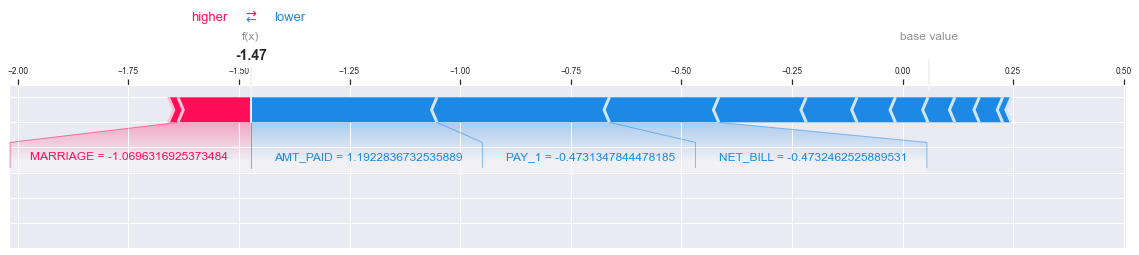

In [33]:
# SHAP values for training example 50 (class = 0)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[50, :],
    X_shap_test.iloc[50, :],
    matplotlib = True,
)

> What this force plot tell us is that for the current predicted example # 50 the score for class 0 was -1.47, while the base value was around 0.10. The plot dissects the impact that all the different features had on the prediction along a spectrum score scale between -2 and 0.5. 
>
>The feature `MARRIAGE` tends to push the score to class 1 (default), while features `AMT_PAID`, `PAY_1`, and `NET_BILL` tend to drive the prediction towards class 0 (no default).

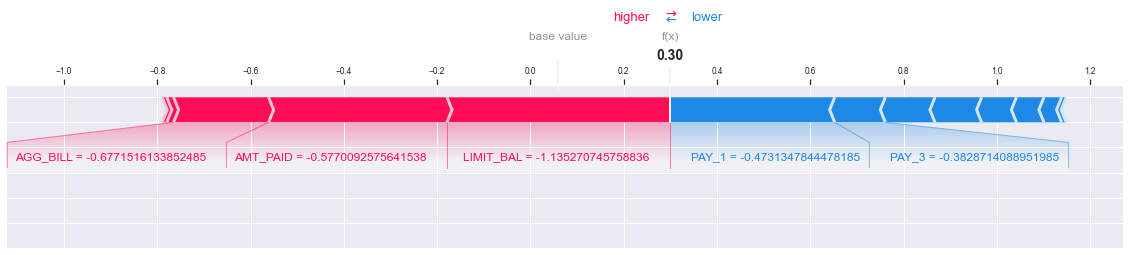

In [34]:
# SHAP values for training example 1001 (class = 1)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[1000, :],
    X_shap_test.iloc[1000, :],
    matplotlib = True,
)

> In the case of predicted example # 1001, the score for the predicted class 1 was 0.30, while the base value was around 0.06. The plot dissects the impact that all the different features had on the prediction along a spectrum score scale between -1 and 1.2. 
>
>The features `AGG_BILL`, `AMT_PAID`, and `LIMIT_BAL` tend to push the score towards class 1 (default), while the features `PAY_1` and `PAY_3` tend to drive the prediction towards class 0 (no default).

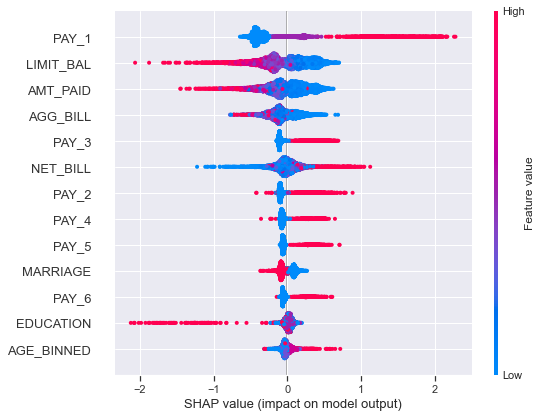

In [35]:
shap.summary_plot(shap_values, X_shap_test)

> This plot summarizes the most important features on average for the prediction of training erxample # 50, along with their corresponding SHAP values. It sorts the features according to the sum of their `SHAP` value magnitudes over all samples, and uses these values to display the distribution of the impacts each feature has on the model output [(source)](https://github.com/slundberg/shap).
>
>We can see that the 5 most determinant features on average are `PAY_1`, `LIMIT_BAL`, `AMT_PAID`, `NET_BILL` and `AGG_BILL`. The values in blue correspond to smaller feature values and the values in red to bigger feature values. 
>
>For instance, a higher value for feature `PAY_1` tends to be associated with the positive class, which means that the client is more likely to default on his/her payment obligations next month. Conversely, A higher value of feature `LIMIT_BAL` tends to be associated with class 0, meaning that the client is more likely to meet his/her payment obligations duly.

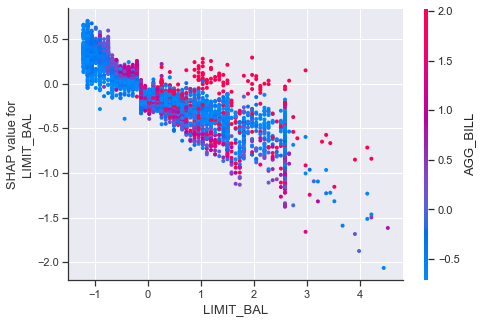

In [36]:
shap.dependence_plot("LIMIT_BAL", shap_values, X_shap_test)

>This plot visualizes the relationship between `LIMIT_BAL` and the prediction, including `NET_BILL` as the interaction term. The latter is selected by the SHAP function by looking into the feature that has [the highest number of interactions](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) with `LIMIT_BAL`. 
>
>From the plot we can see that there appears to be a linear relation between `LIMIT_BAL` and the prediction. As the feature value for `LIMIT_BAL` decreases its `SHAP` value increases, which means the correlation is negative in this case.

### Summary of results

In [38]:
results_data = {
    "Chosen model" : "CatBoost Classifier",
    "Traning set examples" : 24000,
    "Test set examples" : 6000,
    "No. of features used" : 13,
    "Fit time" : 9.4,
    "F1 train score (CV)" : 0.622,
    "F1 val score (CV)" : 0.535,
    "F1 val score (optimized)" : 0.536,
    "Test score" : 0.77,
    "Score time" : 0.01,
    "PAY_1 - SHAP":  0.39,
    "LIMIT_BAL - SHAP" : 0.30,
    "AGG_BILL - SHAP" : 0.20,
    "AMT_PAID - SHAP" : 0.17,
    "NET_BILL - SHAP" : 0.16 
}
pd.DataFrame.from_dict(results_data, orient = "index", columns = ["Value"])

,Value
Chosen model,CatBoost Classifier
Traning set examples,24000
Test set examples,6000
No. of features used,13
Fit time,9.4
F1 train score (CV),0.622
F1 val score (CV),0.535
F1 val score (optimized),0.536
Test score,0.77
Score time,0.01


#### **Concluding remarks**


The table above summarizes the key results obtained using the chosen model `CatBoost Classifier`. Here are the conclusions obtained from this experiment:

* The model seems to provide a decent `f1` score on the test set, but it might have been impacted by optimization bias (see section **Test set results and model evaluation**).
* The most important features for determining the prediction outcome are `PAY_1`, `LIMIT_BAL`, `AGG_BILL`, `AMT_PAID`, and `NET_BILL`. In particular, the first two features appear to be solid predictors for a potential payment default.
* The model doesn't seem to do well in minimizing False Positive predictions (Precision). However, it does slightly better when minimizing False Negatives (Recall).
* We would recommend using this model only to the extent of filtering out customers with a potential risk of default and use these results for informative purposes. The intervention of the risk assessment department might be needed to further evaluate the actual risk that each of these customers may represent, as the model seems to get a considerable amount of False Positives in its predictions. Therefore, we suggest using the magnitude of the SHAP values for each prediction of class 1 as a reference point to conduct these analyses; the closer the SHAP value gets to the base value, the more likely the prediction might not be a True Positive and could thus be thought of a candidate for further review.

#### **Ideas for model improvement:**
* Conduct a more thorough hyperparameter optimization, focused only on improving performance on `CatBoost Classifier`. This model comes with a [rich set of parameters](https://catboost.ai/docs/concepts/parameter-tuning.html) that could be explored in more detail and optimized accordingly.
* Include domain expertise in the process engineering or readjusting features that could potentially minimize the noise in the model.
* If possible, reduce the class imbalance problem by including more class 1 targets.
* Launch a pilot with a small subset of customers to test the model with deployment data and validate the potential impact of optimization bias on the model.